# Mini Project 1

_**Instructions:**_ _Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk._

-- _You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation._

**Response**: First, we note that we will measure the potential profitability by the (current) annualized sample mean of the daily returns, based on data collected over the previous 2 years. On the other hand, we will measure the 'risk' by the sample standard deviation of the log daily returns (taking logs to lessen computational complexity in standard deviation computations). Thus, higher 'risk' portfolios will have greater volatility, and lower risk will have lower volatility. 

An additional measurement of profitability is given by the (sample) third standardised moment, i.e. the sample skewness of daily log returns. Positively skewed data suggests the distribution is favoured above the mean, while negative skew implies favouring below the mean. Likewise, an alternative measurment of 'risk' is given by the (annualized) sample excess kurtosis of the daily log returns. Positive excess kurtosis corresponds to more extreme behaviour in the distribution (i.e. more weights in the tails), while negative excess kurtosis corresponds to less extreme behaviour in the tails. Thus, a positive skew of our data suggests that we may be more profitable, while positive excess kurtosis suggests higher risk.  **FIX THIS PARAGRAPH - should we compute sample skew and kurtosis?**

In both of the following portfolios, we will restrict our attention (for no particular reason) to a combination of ETF's and individual companies for a total of 10 stocks / indexes. We choose the ETF's:  GLD ,VOO, VUG and individual stocks: BAC, BLK, GS, NFLX, NVDA, TMUS, UBER. 

<ins>Potfolio 1: less risky</ins> 

Our goal in this portfolio will be to choose the proportions of our total capital to invest in the 10 stocks such that _the overall volatility of the portfolio is minimised_. Before getting to volatility concerns, we call and investigate the closing price data.

In [1]:
# Import packages required for our quantitative analysis

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

import yfinance as yf

To begin, we gather the relevant stock data into a dataframe. It will be convenient to call the stocks in alphabetical order, since the `covariance' command that we will later use produces a matrix where the rows and columns are indexed by stocks _in alphabetical order_.

In [2]:
tickers = ['BAC','BLK','GLD', 'GS','NFLX','NVDA','TMUS','UBER', 'VOO', 'VUG']

start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

stocks1 = yf.download(tickers, start = start_date, end = end_date, auto_adjust=True)

[*********************100%***********************]  10 of 10 completed


Let us plot the closing prices of the previous listed stocks over the last two years.

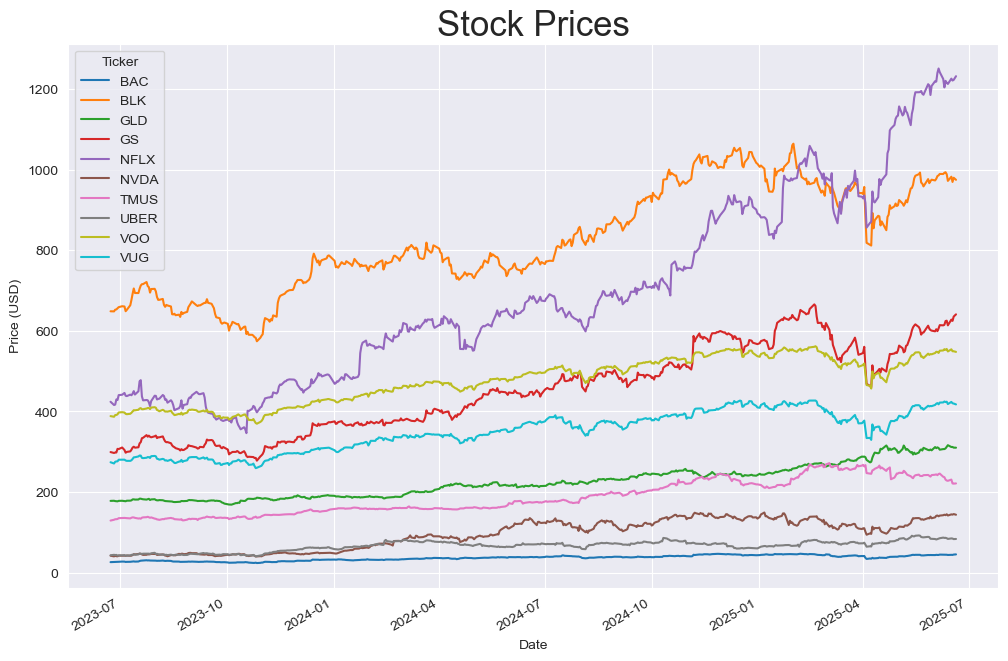

In [3]:
stocks1['Close'].plot(figsize = (12,8))
plt.title(f'Stock Prices', size = 25)
plt.ylabel('Price (USD)')
plt.show()

To give a more accurate comparison of the return on investment of each stock, we plot the _accumulated return on investment_ over the past 2 years.

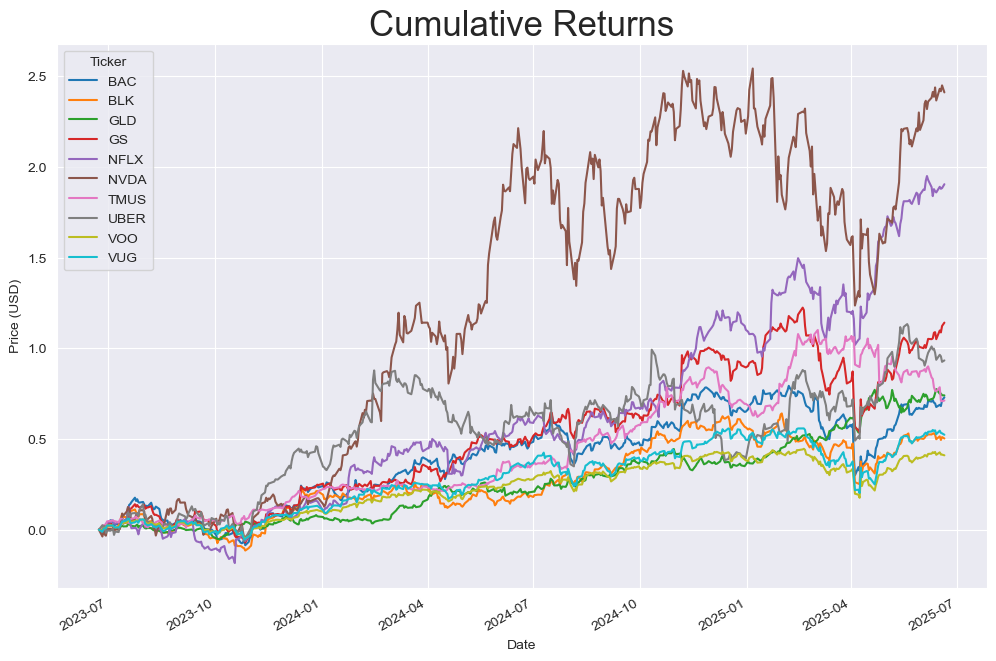

In [4]:
# Add in column to stock data that is cumulative returns of the stocks

# Step 1: Compute cumulative return from 'Close' prices

normalized_returns = stocks1['Close']/stocks1['Close'].iloc[0]-1 

# Moves stock prices to start at 0. 
# That is, here we are computing the return on initial investment (at time zero), by dividing all stock prices by the initial stock price
# and subtracting off 1. This gives the total (cumulative) return at whatever time we are computing things at. 

# Step 2: Create MultiIndex columns for new data

normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame

stocks1 = pd.concat([stocks1, normalized_returns], axis =1 )

stocks1['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Cumulative Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

Let us compute the expected annual return of each stock. To do so, we create dictionary of average daily returns, normalised to yearly, for each stock of interest. 

In [5]:
daily_returns = stocks1['Close']/stocks1['Close'].shift(1)-1
daily_returns = daily_returns.dropna()
expected_stock_returns = np.array([252*np.mean(daily_returns[ticker]) for ticker in tickers])
expected_stock_returns_percentages = {ticker: np.round(100*252*np.mean(daily_returns[ticker]),decimals=2) for ticker in tickers}
expected_stock_returns_percentages

{'BAC': 31.14,
 'BLK': 23.21,
 'GLD': 29.22,
 'GS': 42.52,
 'NFLX': 59.46,
 'NVDA': 75.41,
 'TMUS': 29.48,
 'UBER': 40.89,
 'VOO': 18.63,
 'VUG': 23.43}

So, based off the previous 2 years of closing prices, our stocks of interest will have expected annualized percentage returns as listed above. 

Next, we consider the volatility of our portfolio, which is defined to be the annualized standard deviation of daily log returns. We create a dataframe of daily returns, taking the logs to lessen computational complexity in standard deviation computations.

In [6]:
daily_log_returns = np.log(stocks1['Close']/stocks1['Close'].shift(1))
daily_log_returns = daily_log_returns.dropna()

# Create a dictionary of standard deviations of logs of daily returns, normalizing the results to a yearly measurement by multiplying by sqrt(252)

annualized_volatility = {ticker: np.round(np.std(daily_log_returns[ticker])*np.sqrt(252),decimals=6) for ticker in tickers}
annualized_volatility

{'BAC': 0.262846,
 'BLK': 0.229486,
 'GLD': 0.156091,
 'GS': 0.283615,
 'NFLX': 0.332328,
 'NVDA': 0.516777,
 'TMUS': 0.215922,
 'UBER': 0.388438,
 'VOO': 0.159205,
 'VUG': 0.207695}

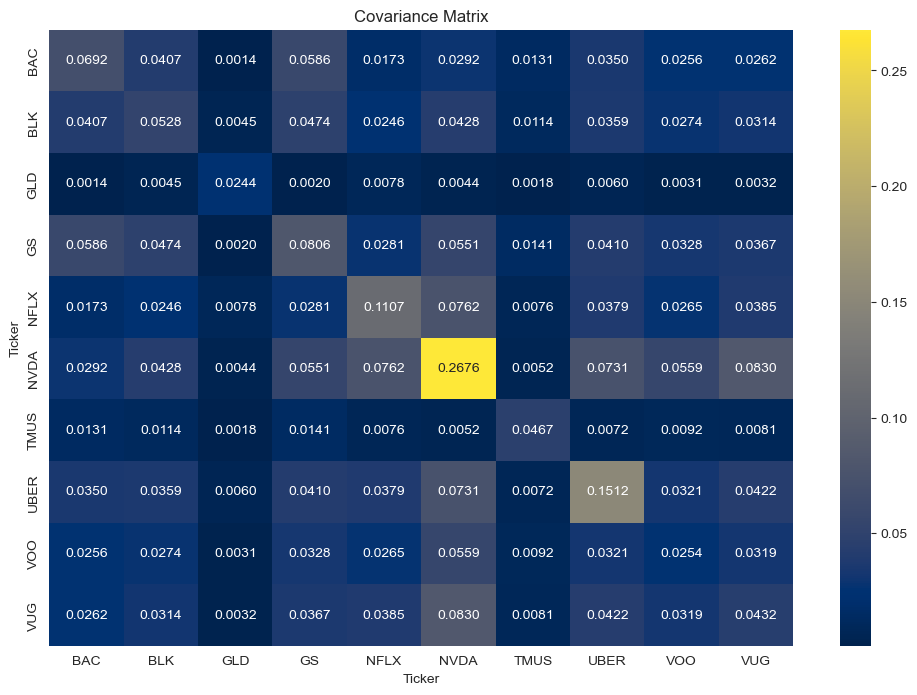

In [8]:
# Compute the covariance matrix of the stocks

covariance_matrix = 252*((daily_log_returns).cov())

# Create a heatmap to visualize the covariance matrix

plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

In [66]:
# Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
# which minimizes a historical portfolio's volatility subject to the following investment constraints

#1) Must invest at least 15% of capital into each index
#2) Cannot invest more than 30% of capital into a single index

# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

#initial_weights = np.array([0,0,0,0.25,0.15,0.15,0,0.15,0.15,0.15])

# Define weight constraints:
# Sum of weights equals 1 
# Allocate at least 3% of capital into each index in stock_symbols
# Do not allocate more than 35% of capital into each index in stock_symbol


max_weight=0.4
min_weight=0

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-min_weight},
              {'type': 'ineq', 'fun': lambda weights: max_weight-max(weights)})

# Define the objective function to minimize portfolio variance

def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Find expected return of portfolio with these weightings
expected_annual_portfolio_return = np.dot(optimal_weights,expected_stock_returns)

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.3f}")
print(f"Exepcted annual return of this portfolio is {100*expected_annual_portfolio_return:.2f}%, while the optimal volatility subject to the constraints is {result.fun:.4f} or {100*result.fun:.2f}%")

Optimal Asset Weights to minimize volatility:
BAC: Weight = 0.001
BLK: Weight = 0.000
GLD: Weight = 0.400
GS: Weight = 0.000
NFLX: Weight = 0.000
NVDA: Weight = -0.000
TMUS: Weight = 0.199
UBER: Weight = 0.000
VOO: Weight = 0.400
VUG: Weight = 0.000
Exepcted annual return of this portfolio is 25.04%, while the optimal volatility subject to the constraints is 0.1121 or 11.21%


Observe the result just as a sanity check:

In [67]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1121385059172392
       x: [ 1.073e-03  1.128e-06  4.000e-01  2.454e-05  9.662e-06
           -8.298e-18  1.989e-01  5.309e-05  4.000e-01  1.175e-05]
     nit: 43
     jac: [ 1.202e-01  1.347e-01  1.013e-01  1.498e-01  1.363e-01
            2.244e-01  1.220e-01  1.492e-01  1.181e-01  1.397e-01]
    nfev: 596
    njev: 43

Comparing with the volatilities of the individual stocks:

In [27]:
annualized_volatility

{'BAC': 0.262846,
 'BLK': 0.229486,
 'GLD': 0.156091,
 'GS': 0.283615,
 'NFLX': 0.332328,
 'NVDA': 0.516777,
 'TMUS': 0.215922,
 'UBER': 0.388438,
 'VOO': 0.159205,
 'VUG': 0.207695}

we see that taking the portfolio above with the weights given will have less volatility than each individual stock. To conclude, the portfolio we have constructed here is given by: 0.001(BAC) + 0.400(GLD) + 0.199(TMUS) + 0.400(VOO).

**Questions** Depending on the max_weight and min_weight that I set (eg max=0.45, min=0) sometimes I get negative weights... why is this happening?? What is going on here? Also, I get a ridiculous answer when I input max=0.42, min=0). It seems that optimize should be taken with a grain of salt. Check the result just to be sure things were executed correctly.

<ins>Potfolio 2: more risky</ins>

For the more risky portfolio, we will make a choice from the same 10 stocks. To choose the weights, we will maximise the expect return of the stocks.

https://finance.yahoo.com/markets/stocks/trending/. We choose the following stocks: SRM, RKLB, LEU. (MAYBE).

In [70]:
# Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
# which MAXIMISES a historical portfolio's expected return subject to the following investment constraints:

# 1) Not allowed to short any stock (all stock weights must be non-negative)
# 2) Cannot invest more than 40% of capital into a single index

# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
# initial_weights = np.array([1/n_assets] * n_assets)
initial_weights = np.array([0,0,0,0.25,0.15,0.15,0,0.15,0.15,0.15])

# Define weight constraints:
# Sum of weights equals 1 
# Allocate at least 3% of capital into each index in stock_symbols
# Do not allocate more than 30% of capital into each index in stock_symbol

max_weight=0.4
min_weight=0

constraints1 = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-min_weight},
              {'type': 'ineq', 'fun': lambda weights: max_weight-max(weights)})

# Define the objective function to minimize portfolio variance

def portfolio_return(weights):
    return -np.dot(weights, expected_stock_returns)

# Run the optimization to find the optimal weights
result2 = minimize(portfolio_return, initial_weights, constraints=constraints1)

# Optimal asset weights
optimal_weights2 = result2.x

# Find expected return of portfolio with these weightings
expected_annual_portfolio_return2 = np.dot(optimal_weights2,expected_stock_returns)

# Find the volatility of this portfolio
portfolio_std_dev2 = np.sqrt(np.dot(optimal_weights2.T, np.dot(covariance_matrix, optimal_weights2)))

# Print the optimal weights and expected returns
print("Optimal Asset Weights to maximise return:")
for ticker, weight in zip(tickers, optimal_weights2):
    print(f"{ticker}: Weight = {weight:.2f}")

print(f"Maximal expected annual return of portfolio is {100*expected_annual_portfolio_return2:.2f}%, while the volatility is {portfolio_std_dev2:.4f} or {100*portfolio_std_dev2:.2f}%")

Optimal Asset Weights to maximise return:
BAC: Weight = -0.00
BLK: Weight = -0.00
GLD: Weight = -0.00
GS: Weight = 0.21
NFLX: Weight = 0.40
NVDA: Weight = 0.41
TMUS: Weight = -0.00
UBER: Weight = 0.00
VOO: Weight = -0.00
VUG: Weight = -0.00
Maximal expected annual return of portfolio is 63.11%, while the volatility is 0.3222 or 32.22%


In [110]:
# Gather the stock data into a dataframe

tickers2 = ['SRM', 'RKLB', 'LEU','NVDA','UBER']

start_date = dt.datetime.today()-dt.timedelta(days = 527)
end_date = dt.datetime.today()

stocks2 = yf.download(tickers2, start = start_date, end = end_date, auto_adjust=True)

[*********************100%***********************]  5 of 5 completed


In [ ]:
# Plot the closing prices of the previous listed stocks over the last two years

stocks2['Close'].plot(figsize = (12,8))
plt.title(f'Stock Prices', size = 25)
plt.ylabel('Price (USD)')
plt.show()

In [ ]:
# Add in column to stock data that is cumulative returns of the stocks

# Step 1: Compute cumulative return from 'Close' prices

normalized_returns2 = stocks2['Close']/stocks2['Close'].iloc[0]-1 

# Moves stock prices to start at 0. 
# That is, here we are computing the return on initial investment (at time zero), by dividing all stock prices by the initial stock price
# and subtracting off 1. This gives the total (cumulative) return at whatever time we are computing things at. 

# Step 2: Create MultiIndex columns for new data

normalized_returns2.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns2.columns])

# Step 3: Concatenate to the original DataFrame

stocks2 = pd.concat([stocks2, normalized_returns2], axis =1 )


In [ ]:
# Plot cumulative returns of the previous listed stocks over the last two years

stocks2['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Cumulative Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

In [ ]:
# Create dictionary of average/expected daily return for indexes in stock_symbols normalized for yearly return

daily_returns2 = stocks2['Close']/stocks2['Close'].shift(1)-1
daily_returns2 = daily_returns2.dropna()
expected_returns2 = {ticker: 252*np.mean(daily_returns2[ticker]) for ticker in tickers}
expected_returns2

In [ ]:
# We now consider the volatility of our portfolio, which is defined to be the annualized standard deviation of daily log returns.

# We create a dataframe of daily returns, taking the logs to lessen computational complexity in standard deviation computations

daily_log_returns2 = np.log(stocks2['Close']/stocks2['Close'].shift(1))
daily_log_returns2 = daily_log_returns2.dropna()

# Create a dictionary of standard deviations of daily returns, normalizing the results to a yearly measurement by multiplying by sqrt(252)

annualized_volatility2 = {ticker: np.std(daily_log_returns2[ticker])*np.sqrt(252) for ticker in tickers}

# Compute the covariance matrix of the stocks

covariance_matrix2 = 252*((daily_returns2).cov())
covariance_matrix2

In [ ]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix2, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()